In [1]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.tree import DecisionTreeClassifier

In [2]:
# helper function to plot curves
def make_plot(metric_values, train_values, cv_values, model_name, metric_name, score_name, curve_type):
    
    fig = plt.figure()
    ax = plt.gca()
    ax.plot(metric_values, train_values, label='Training score')
    ax.plot(metric_values, cv_values, label='CV score')
    ax.set_xlabel(metric_name)
    ax.set_ylabel(score_name)
    title = '{} curve for {} ({})'.format(curve_type, model_name, score_name)
    ax.set_title(title)
    ax.legend()
    
def plot_curve(model, model_name, X, y, param_name, scoring, curve_type, param_range=None):
    
    if curve_type == 'Validation':
        train_scores, cv_scores = validation_curve(model, X, y,
                                                   param_name=param_name, 
                                                   param_range=param_range, 
                                                   scoring=scoring,
                                                   cv=5,
                                                   n_jobs=-1)
    elif curve_type == 'Learning':
        train_sizes, train_scores, cv_scores = learning_curve(model, X, y,
                                                              train_sizes=np.linspace(.1, 1.0, 100),
                                                              scoring=scoring,
                                                              cv=5,
                                                              n_jobs=-1)
        param_range = train_sizes
        
    train_score_means = np.mean(train_scores, axis=1)
    cv_score_means = np.mean(cv_scores, axis=1)
    
    make_plot(metric_values=param_range,
              train_values=train_score_means,
              cv_values = cv_score_means,
              model_name=model_name, 
              metric_name=param_name.capitalize().replace('_',' '),
              score_name=scoring.capitalize(),
              curve_type=curve_type
             )

## Red & White Wine Dataset

In [3]:
df_white = pd.read_csv('winequality-white.csv', sep=';')
df_red = pd.read_csv('winequality-red.csv', sep=';')

df_white['type'] = ['white'] * len(df_white)
df_red['type'] = ['red'] * len(df_red)

df = pd.concat([df_white, df_red])

X = df.drop(['quality', 'type'], axis=1) 
y = df['type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=2020) 

# In data_exploration we see almost all features have a normal distribution 
# So it makes sense to use StandardScaler
scaler = StandardScaler()
encoder = LabelEncoder() 

# Apply the scaler on train and test data separately
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns) 
y_train = encoder.fit_transform(y_train)

X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns) 
y_test = encoder.fit_transform(y_test)

**Fit a basic decision tree.**

In [4]:
clf = DecisionTreeClassifier(random_state=2020)

**Look at how tree depth affects classifier accuracy. Max tree depth is the number of features.**

CPU times: user 113 ms, sys: 54.2 ms, total: 168 ms
Wall time: 2.16 s


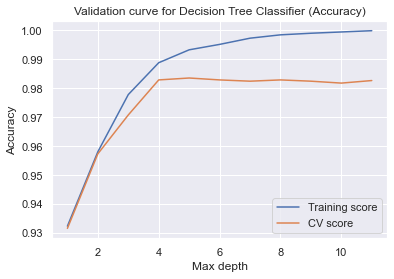

In [5]:
%%time
depth_values = list(range(1,len(X.columns) + 1))
plot_curve(model=clf,
           model_name='Decision Tree Classifier', 
           X=X_train, 
           y=y_train, 
           param_name='max_depth', 
           param_range=depth_values, 
           scoring='accuracy', 
           curve_type='Validation')

**We can see that training accuracy is increasing with tree depth, but cross-validation accuracy plateaus after depth 4.**

**Now perform grid search. We know tree depth is best after 4. 'Gini' and 'entropy' are the only available split criteria.** 

In [6]:
%%time
search_parameters = {'criterion':('gini', 'entropy'),
                     'max_depth':list(range(4,11))
                    }
gs_clf = GridSearchCV(clf, search_parameters, cv=5, scoring='accuracy', n_jobs=-1)
gs_clf.fit(X_train, y_train)
print(gs_clf.best_params_)

{'criterion': 'entropy', 'max_depth': 9}
CPU times: user 86.4 ms, sys: 10.2 ms, total: 96.6 ms
Wall time: 413 ms


**Now use these best parameters to create a new model and check its train time.**

In [7]:
%%time
clf = DecisionTreeClassifier(criterion='entropy', 
                             max_depth=9, 
                             random_state=2020
                            )
clf.fit(X_train, y_train)

CPU times: user 16.5 ms, sys: 1.32 ms, total: 17.9 ms
Wall time: 16.8 ms


DecisionTreeClassifier(criterion='entropy', max_depth=9, random_state=2020)

**Plot the learning curve.**

CPU times: user 518 ms, sys: 57.6 ms, total: 575 ms
Wall time: 2.19 s


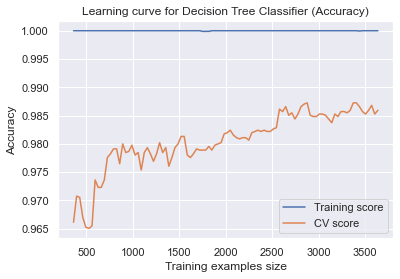

In [8]:
%%time
plot_curve(model=clf,
           model_name='Decision Tree Classifier', 
           X=X_train, 
           y=y_train, 
           param_name='Training examples size', 
           scoring='accuracy', 
           curve_type='Learning')

**We can see that the tree does not need a lot of samples to increase its CV accuracy, though it incrementally does better with larger training sample sizes.**

**Now check how the model performs on test data.**

In [9]:
%%time
y_predicted = clf.predict(X_test)

CPU times: user 2.58 ms, sys: 540 µs, total: 3.12 ms
Wall time: 3 ms


In [10]:
print(classification_report(y_test, y_predicted, digits=4))

              precision    recall  f1-score   support

           0     0.9834    0.9633    0.9733       491
           1     0.9877    0.9945    0.9911      1459

    accuracy                         0.9867      1950
   macro avg     0.9856    0.9789    0.9822      1950
weighted avg     0.9866    0.9867    0.9866      1950



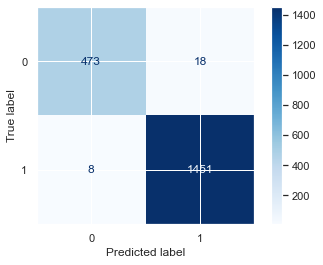

In [11]:
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, display_labels=[0,1]);

## Shill Bidding Dataset

In [12]:
df = pd.read_csv("Shill Bidding Dataset.csv")

X = df.drop(['Record_ID', 'Auction_ID', 'Bidder_ID', 'Class'], axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=2020) 

# Use MinMaxScaler because data has outliers, and we want to highlight those
scaler = MinMaxScaler() 

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns) 
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns) 

**Train a basic tree.**

In [13]:
clf = DecisionTreeClassifier(random_state=2020)

**Look at how tree depth affects classifier recall.**

CPU times: user 79.9 ms, sys: 8.78 ms, total: 88.6 ms
Wall time: 249 ms


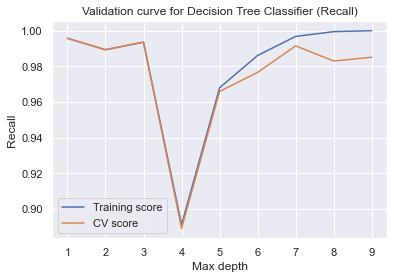

In [14]:
%%time 
depth_values = list(range(1,len(X.columns) + 1))
plot_curve(model=clf,
           model_name='Decision Tree Classifier', 
           X=X_train, 
           y=y_train, 
           param_name='max_depth', 
           param_range=depth_values, 
           scoring='recall', 
           curve_type='Validation')

**We can see cross_validation recall dips after depth 3, and never gets higher, while the training accuracy continues to increase, indicatin that the tree is starting to overfit.**

**Now perform grid search. We know the best tree depth is 3, so we won't be searching over it. 'Gini' and 'entropy' are the only available split criteria. Class weight is "balanced" to automatically adjust weights inversely proportional to class frequencies in the input data per sklearn documentation. We want to capture the outliers.** 

In [15]:
%%time
search_parameters = {'criterion':('gini', 'entropy'),
                     'class_weight':['balanced']
             }
gs_clf = GridSearchCV(clf, search_parameters, cv=5, scoring='recall', n_jobs=-1)
gs_clf.fit(X_train, y_train)
print(gs_clf.best_params_)

{'class_weight': 'balanced', 'criterion': 'entropy'}
CPU times: user 32 ms, sys: 3.77 ms, total: 35.8 ms
Wall time: 96.1 ms


**Train the best model.**

In [16]:
%%time
clf = DecisionTreeClassifier(class_weight='balanced', 
                             criterion='entropy', 
                             max_depth=3, 
                             random_state=2020
                            )
clf.fit(X_train, y_train)

CPU times: user 9.77 ms, sys: 1.13 ms, total: 10.9 ms
Wall time: 15 ms


DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=3, random_state=2020)

**Check the learning curve.**

CPU times: user 729 ms, sys: 83.7 ms, total: 813 ms
Wall time: 2.35 s


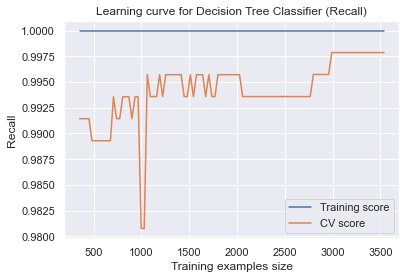

In [17]:
%%time
plot_curve(model=clf,
           model_name='Decision Tree Classifier', 
           X=X_train, 
           y=y_train, 
           param_name='Training examples size', 
           scoring='recall', 
           curve_type='Learning')

**We can see that with more examples, CV error stays low but then continues to increase, indicating somewhat high variance in the model.**

**Now check performance on test data.**

In [18]:
%%time
y_predicted = clf.predict(X_test)

CPU times: user 1.84 ms, sys: 486 µs, total: 2.33 ms
Wall time: 2.45 ms


In [19]:
print(classification_report(y_test, y_predicted, digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.9840    0.9919      1690
           1     0.8846    1.0000    0.9388       207

    accuracy                         0.9858      1897
   macro avg     0.9423    0.9920    0.9654      1897
weighted avg     0.9874    0.9858    0.9861      1897



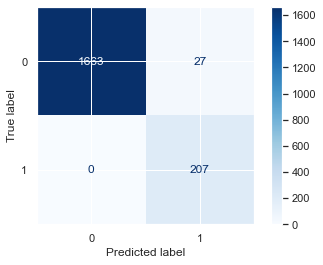

In [20]:
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, display_labels=[0,1]);